# Predicting reorder

This notebook is about predicting what the customer will reorder based on past purchases. There are some features from orginal data that I will not include in prediction, for example: add_to_cart, aisle, and order_hour_of_day. The dataframe that will be used is df_used.csv. The models will be evaluated based on the f1 score. F1 score of class 1 means 'item will be reordered'.

## Importing library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, classification_report

In [21]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.models import load_model
from keras import callbacks

## Train Test Split

In [2]:
# load data
df_used = pd.read_csv('df_used.csv')

In [3]:
# define the X and y variables
X = df_used.drop(columns=['user_id', 'product_id', 'reordered'])
y = df_used['reordered']

In [4]:
y.value_counts()

1.0    5648095
0.0    4545217
Name: reordered, dtype: int64

The y does not look that imbalance

In [4]:
# split into X and X_test & y and y_test
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20, stratify=y, random_state=1)

In [6]:
# check the shape
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(8154649, 67)
(8154649,)
(2038663, 67)
(2038663,)


In [5]:
# splitting into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size= 0.80, stratify=y, random_state=1)

In [7]:
# check the shape
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(6523719, 67)
(6523719,)
(1630930, 67)
(1630930,)


In [6]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
X_val_ss = scaler.transform(X_val)
X_ss = scaler.transform(X)

In [11]:
def confusion(y, y_pred):
    # Build the confusion matrix as a dataframe
    confusion_df = pd.DataFrame(confusion_matrix(y, y_pred), columns=['Predicted 0', 'Predicted 1'])

    # Add a column that sums up the actuals
    confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)

    # Add a row that sums up the predictions
    confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)

    # Fix the indices
    confusion_df.index=['Actual 0', 'Actual 1', 'Sum of Predictions'] 
    
    # Check
    return confusion_df

## Model - Random Forest

To control the model complexity in Random Forest, the parameters that needs to be tune in:
- n_estimator
- max_depth

In [ ]:
# finding max_depth
f1_train_rfd =[]
f1_val_rfd=[]
depth = [5, 10, 15]
for d in depth:
    rfc1 = RandomForestClassifier(max_depth=d, n_jobs=-1)
    rfc1.fit(X_train_ss, y_train)
    # append train score
    f1_train_rfd.append(f1_score(y_train, rfc1.predict(X_train_ss)))
    # append validation score
    f1_val_rfd.append(f1_score(y_val, rfc1.predict(X_val_ss)))

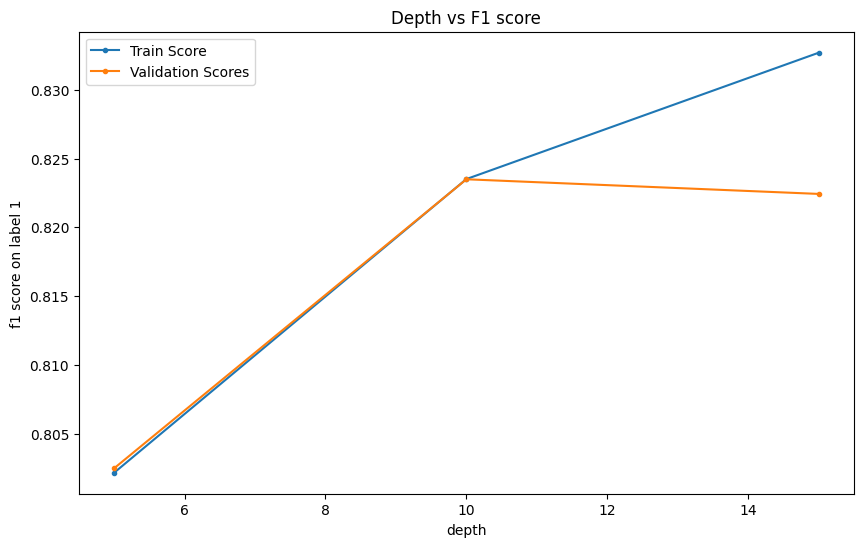

In [10]:
# plot 
plt.figure(figsize=(10,6))
plt.plot(depth, f1_train_rfd, label="Train Score", marker=".")
plt.plot(depth, f1_val_rfd, label="Validation Scores", marker=".")
plt.xlabel("depth")
plt.ylabel("f1 score on label 1")
plt.title("Depth vs F1 score")
plt.legend()
plt.show()

The best depth is 10.

In [11]:
# finding max_estimators
f1_train_rfest =[]
f1_val_rfest=[]
estimators= [40, 70, 100]
for n in estimators:
    rfc = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    rfc.fit(X_train_ss, y_train)
    # append train score
    f1_train_rfest.append(f1_score(y_train, rfc.predict(X_train_ss)))
    # append validation score
    f1_val_rfest.append(f1_score(y_val, rfc.predict(X_val_ss)))

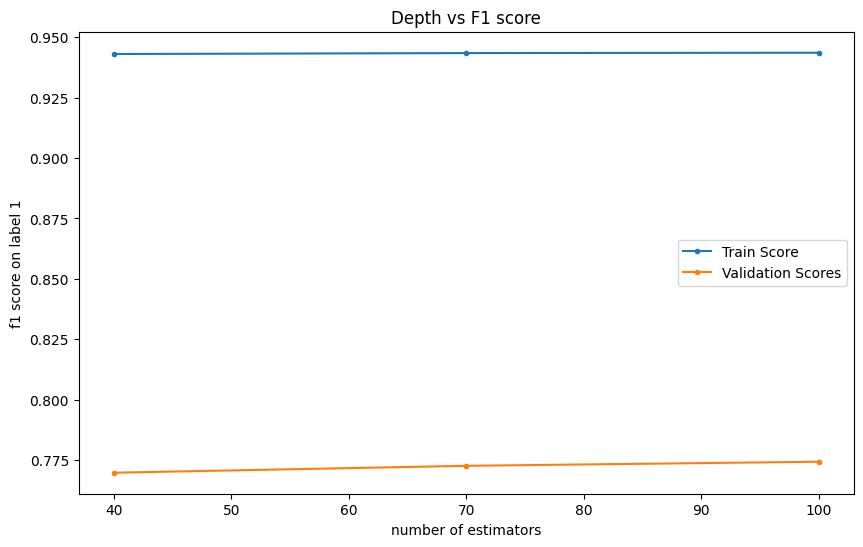

In [12]:
# plot 
plt.figure(figsize=(10,6))
plt.plot(estimators, f1_train_rfest, label="Train Score", marker=".")
plt.plot(estimators, f1_val_rfest, label="Validation Scores", marker=".")
plt.xlabel("number of estimators")
plt.ylabel("f1 score on label 1")
plt.title("Depth vs F1 score")
plt.legend()
plt.show()

It seems that different number of estimators does not have sunstantial difference in f1 score so I will use the default which is 100.

In [8]:
# fit the best parameter
bestrf = RandomForestClassifier(max_depth=10, n_jobs=-1)
bestrf.fit(X_ss, y)

RandomForestClassifier(max_depth=10, n_jobs=-1)

In [12]:
# get confusion df
y_pred_rf = bestrf.predict(X_test_ss)
confusion(y_test, y_pred_rf)

/tmp/ipykernel_349/468895355.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)


,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,698587,210457,909044
Actual 1,194377,935242,1129619
Sum of Predictions,892964,1145699,2038663


In [50]:
# get f1 score
f1_rf = f1_score(y_test, y_pred_rf)
f1_rf

0.8220758592864822

In [14]:
# print classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78    909044
         1.0       0.82      0.83      0.82   1129619

    accuracy                           0.80   2038663
   macro avg       0.80      0.80      0.80   2038663
weighted avg       0.80      0.80      0.80   2038663



The f1 score for random forest is 0.82 and the classes (precision and recall) look pretty balance.

## Model - XGBoost

The paramaters that needs to be tune in:
- max_depth -- control model complexity
- eta -- add randomness to make training robust to noise


In [18]:
# find depth
train_scores = []
validation_scores = []
depth = [3,5,6,8]
for d in depth:
    xgb = XGBClassifier(max_depth=d, n_jobs=-1)
    xgb.fit(X_train_ss, y_train)
    # train scores
    train_scores.append(xgb.score(X_train_ss, y_train))
    # validation scores
    validation_scores.append(xgb.score(X_val_ss, y_val))

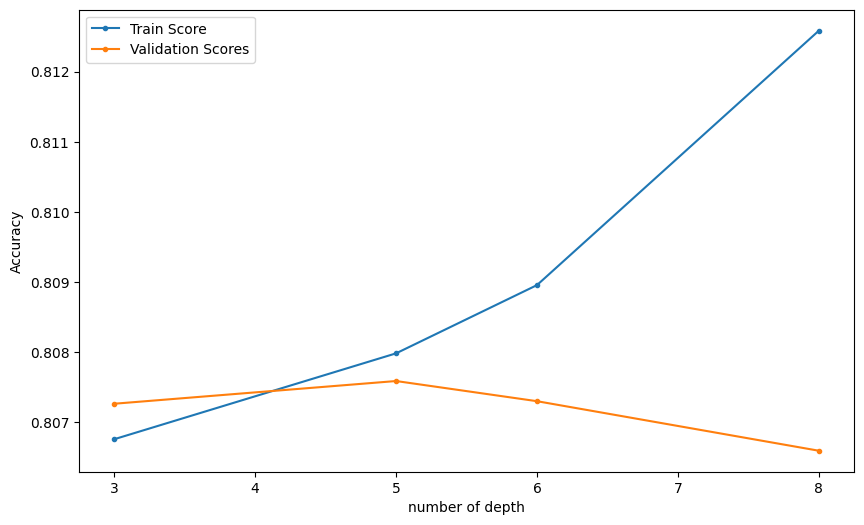

In [19]:
# plot 
plt.figure(figsize=(10,6))
plt.plot(depth, train_scores, label="Train Score", marker=".")
plt.plot(depth, validation_scores, label="Validation Scores", marker=".")
plt.xlabel("number of depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
# find the eta
train_scores = []
validation_scores = []
num = [0.075, 0.1, 0.25, 0.5]
for n in num:
    xgb = XGBClassifier(eta=n, max_depth = 5, n_jobs=-1)
    xgb.fit(X_train_ss, y_train)
    # train scores
    train_scores.append(xgb.score(X_train_ss, y_train))
    # test scores
    validation_scores.append(xgb.score(X_val_ss, y_val))

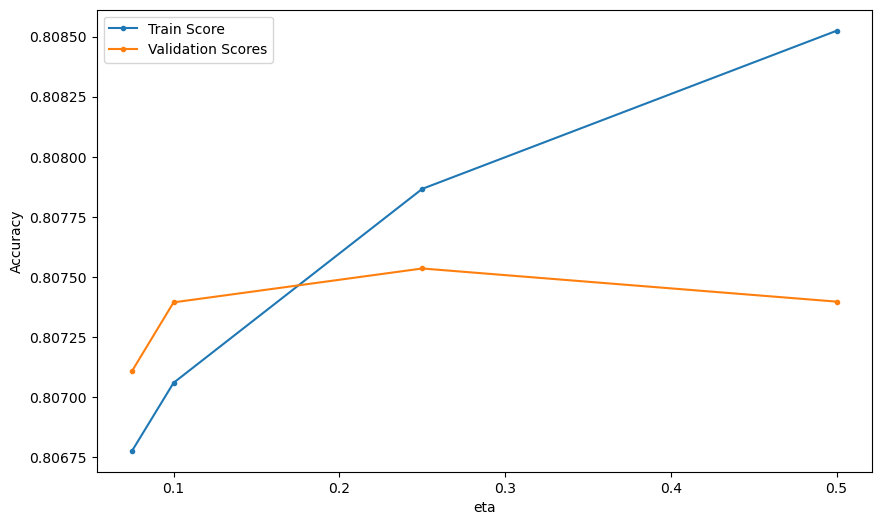

In [16]:
plt.figure(figsize=(10,6))
plt.plot(num, train_scores, label="Train Score", marker=".")
plt.plot(num, validation_scores, label="Validation Scores", marker=".")
plt.xlabel("eta")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The best parameters: eta = 0.25 and max_depth = 5

In [17]:
# fit the best parameter
bestxgb = XGBClassifier(max_depth=5, eta=0.25, n_jobs=-1)
bestxgb.fit(X_ss, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.25,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [18]:
# get confusion df
y_pred_xgb = bestxgb.predict(X_test_ss)
confusion(y_test, y_pred_xgb)

/tmp/ipykernel_349/468895355.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)


,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,690337,218707,909044
Actual 1,174394,955225,1129619
Sum of Predictions,864731,1173932,2038663


In [51]:
# get f1 score
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_xgb

0.8293499905146445

In [19]:
# print classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78    909044
         1.0       0.81      0.85      0.83   1129619

    accuracy                           0.81   2038663
   macro avg       0.81      0.80      0.80   2038663
weighted avg       0.81      0.81      0.81   2038663



The f1 score XGBoost is slightly better than random forest: 0.83. The classes(precision and recall) looks pretty balance too.

## Model1 - Neural Network

For this neural network, I will only use the X_ss and X_test. So, no validation.

In [22]:
# without initializer and regularizer
# create a sequential model
model1= Sequential()
# declare the hidden layer
model1.add(Dense(1024, activation='relu', input_dim=X_ss.shape[1]))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
# declare the output layer
model1.add(Dense(1, activation='sigmoid'))

2022-10-30 13:38:57.851912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              69632     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [24]:
# model compile
model1.compile(
    # Optimizer
    optimizer='adam',
    # Loss function to minimize
    loss='binary_crossentropy',
    # Metric used to evaluate model
    metrics='accuracy'
)

In [28]:
# train the model
hist_1 = model1.fit(X_ss, y, batch_size=1024, epochs = 11,
                    validation_data=(X_test_ss, y_test))

Epoch 1/11
7964/7964 [==============================] - 597s 75ms/step - loss: 0.4008 - accuracy: 0.8066 - val_loss: 0.4004 - val_accuracy: 0.8069
Epoch 2/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3997 - accuracy: 0.8069 - val_loss: 0.3997 - val_accuracy: 0.8070
Epoch 3/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3991 - accuracy: 0.8071 - val_loss: 0.3987 - val_accuracy: 0.8071
Epoch 4/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3987 - accuracy: 0.8073 - val_loss: 0.3988 - val_accuracy: 0.8069
Epoch 5/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3984 - accuracy: 0.8075 - val_loss: 0.3982 - val_accuracy: 0.8074
Epoch 6/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3981 - accuracy: 0.8077 - val_loss: 0.3980 - val_accuracy: 0.8074
Epoch 7/11
7964/7964 [==============================] - 594s 75ms/step - loss: 0.3977 - accuracy: 0.8078 - val_loss: 0

In [29]:
model1.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


In [30]:
# get y_pred
y_pred = model1.predict(X_test_ss)
y_pred_test = [1 if i>=0.5 else 0 for i in y_pred]
# find f1 score
f1_model1 = f1_score(y_test, y_pred_test)
f1_model1

63709/63709 [==============================] - 238s 4ms/step


0.825652696770823

In [31]:
# get confusion df
confusion(y_test, y_pred_test)

/tmp/ipykernel_349/468895355.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)


,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,716931,192113,909044
Actual 1,200344,929275,1129619
Sum of Predictions,917275,1121388,2038663


In [32]:
# print classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79    909044
         1.0       0.83      0.82      0.83   1129619

    accuracy                           0.81   2038663
   macro avg       0.81      0.81      0.81   2038663
weighted avg       0.81      0.81      0.81   2038663



The f1 score for model1 neural network is the same as XGBoost 0.83. The classes are also looks prettybalanced.

## Model 2 - Neural Network

In [38]:
# with initializer and regularizer
initializer = HeNormal(seed=None)
regularizer = 'l2'
# create a sequential model
model2= Sequential()
# declare the hidden layer
model2.add(Dense(512, activation='relu', input_dim=X_train_ss.shape[1], kernel_initializer = initializer, kernel_regularizer= regularizer))
model2.add(Dense(512, activation='relu',kernel_initializer = initializer, kernel_regularizer=regularizer))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu',kernel_initializer = initializer, kernel_regularizer=regularizer))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu',kernel_initializer = initializer, kernel_regularizer=regularizer))
model2.add(Dense(64, activation='relu',kernel_initializer = initializer, kernel_regularizer=regularizer))
# declare the output layer
model2.add(Dense(1, activation='sigmoid'))

In [39]:
# model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               34816     
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                      

In [40]:
# model compile
model2.compile(
    # Optimizer
    optimizer='adam',
    # Loss function to minimize
    loss='binary_crossentropy',
    # Metric used to evaluate model
    metrics='accuracy'
)

In [41]:
# adding earlystopping to stop the neural network
earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=11, restore_best_weights=True)

In [43]:
# model fit
hist2 = model2.fit(X_ss, y, batch_size=1024, epochs = 30,
                    validation_data=(X_test_ss, y_test), callbacks=[earlystopping])

Epoch 1/30
7964/7964 [==============================] - 463s 58ms/step - loss: 0.4229 - accuracy: 0.8043 - val_loss: 0.4208 - val_accuracy: 0.8039
Epoch 2/30
7964/7964 [==============================] - 460s 58ms/step - loss: 0.4193 - accuracy: 0.8042 - val_loss: 0.4210 - val_accuracy: 0.7919
Epoch 3/30
7964/7964 [==============================] - 460s 58ms/step - loss: 0.4187 - accuracy: 0.8043 - val_loss: 0.4157 - val_accuracy: 0.8053
Epoch 4/30
7964/7964 [==============================] - 461s 58ms/step - loss: 0.4180 - accuracy: 0.8041 - val_loss: 0.4139 - val_accuracy: 0.8043
Epoch 5/30
7964/7964 [==============================] - 460s 58ms/step - loss: 0.4177 - accuracy: 0.8042 - val_loss: 0.4138 - val_accuracy: 0.8053
Epoch 6/30
7964/7964 [==============================] - 461s 58ms/step - loss: 0.4176 - accuracy: 0.8041 - val_loss: 0.4146 - val_accuracy: 0.8050
Epoch 7/30
7964/7964 [==============================] - 460s 58ms/step - loss: 0.4175 - accuracy: 0.8041 - val_loss: 0

In [44]:
model2.save('model2')

INFO:tensorflow:Assets written to: model2/assets


In [45]:
#  get y_predict
y_pred2 = model2.predict(X_test_ss)
y_pred_test2 = [1 if i>=0.5 else 0 for i in y_pred2]
# find f1 score
f1_model2 = f1_score(y_test, y_pred_test2)
f1_model2

63709/63709 [==============================] - 206s 3ms/step


0.8286961088812954

In [46]:
# get confusion df
confusion(y_test, y_pred_test2)

/tmp/ipykernel_349/468895355.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)


,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,683848,225196,909044
Actual 1,171089,958530,1129619
Sum of Predictions,854937,1183726,2038663


In [47]:
# print classification report
print(classification_report(y_test, y_pred_test2))

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78    909044
         1.0       0.81      0.85      0.83   1129619

    accuracy                           0.81   2038663
   macro avg       0.80      0.80      0.80   2038663
weighted avg       0.81      0.81      0.80   2038663



All the f1 score from 4 models are around the same, xgboost got slightly better f1 value. 
- f1 random forest = 0.822
- f1 xgboost = 0.829
- f1 nn1 = 0.826
- f1 nn2 = 0.827